# Are the response times different between neighbourhoods + weather
This notebook will explore the response times with respect to time, neighbourhoods and weather.

## 1. Preparing the data

### 1.1 Incident data
The dataset that will be used is the previously cleaned dataset that contains information about the fire incidents and the mobilisation records. The dataset has already been enriched with more geograhical information as previously explained. 
In this part the dataset for modelling will be prepared. Since the focus is on exploring the differences in response time all the rows that do not contain that information will be filtered out. Columns that are deemed unneccessary are also removed so that the dataset is more concise. Here we are only conserned witht the first responding attendance time. The reason being that the first responding attendance time is the best comparison we have to be able to see if any specific area is being better/worse serviced then others.

In [1]:
# Import necessary libraries and apply settings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import Image
%matplotlib inline
import json
import fiona
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
from bokeh.palettes import Reds6 as palette
from bokeh.plotting import figure, save
from bokeh.resources import CDN
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep

In [64]:
# Load the previously cleaned dataset
incidents = pd.read_csv('fire_incidents2020.csv')#pd.read_csv('fire_incidents1year.csv')
incidents = incidents.append(pd.read_csv('fire_incidents2019.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2018.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2017.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2016.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2015.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2014.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2013.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2012.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2011.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2010.csv'));
incidents = incidents.append(pd.read_csv('fire_incidents2009.csv'));

# Extract length of dataframe and the number of rows that contain attendance time
len(incidents), incidents.AttendanceTimeSeconds.count()

(1219414, 1123899)

It seems that we do not have data about the response time for all incidents, since that is dependent on there having been mobalised at least one fire truck. For the analysis we will be filtering on those incidents that include information about response time regardless of the incident type.

In [66]:
incidents = incidents.dropna(axis=0, subset=['AttendanceTimeSeconds'])

In [67]:
incidents = incidents[['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall',
       'HourOfCall', 'IncidentGroup', 'StopCodeDescription',
       'SpecialServiceType', 'PropertyCategory', 'PropertyType',
       'AddressQualifier', 'Postcode', 'Postcode_district',
       'IncGeo_BoroughCode', 'ProperCase', 'WardCode',
       'Easting', 'Northing', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_AttendanceTime',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 
        'Population', 'Households','Altitude',
       'London zone', 'Average Income', 'Latitude', 'Longitude', 'WardName',
       'ResourceMobilisationID', 'Resource_Code', 'AttendanceTimeSeconds',
        'DeployedFromStation_Code',
       'DeployedFromStation_Name', 'DeployedFromLocation', 'MobilisationOrder',
       'PlusCode_code', 'PlusCode_Description', 'DelayCodeID',
       'DelayCode_Description', 'PerformanceReporting']]


If we explore how frequently the attendance time column contains data we can see that the numbers are deacreasing from 2009 where they reached a maximum. This corresponds to the number of incidents decreasing from 2009 as was shown previously. The numbers for 2020 are ofcourse the lowest since that year is still not over.

In [68]:
incidents.groupby('CalYear').count()['AttendanceTimeSeconds']

CalYear
2009    123061
2010    112545
2011    104665
2012     98440
2013     94870
2014     89359
2015     91753
2016     98903
2017     97103
2018     99402
2019     98739
2020     15059
Name: AttendanceTimeSeconds, dtype: int64

Finally we modify the dataframe and add additional information about the time of the call. This is done to prepare the dataset for additional weather data that will be joined to it.

In [69]:
# Convert datetime to date
incidents.DateOfCall = pd.to_datetime(incidents.DateOfCall)

# Add columns for month, week, weekday
incidents['Month'] = incidents.DateOfCall.dt.month
incidents['Week'] = incidents.DateOfCall.dt.week
incidents['Weekday'] = incidents.DateOfCall.dt.weekday # 0 is monday, 6 is sunday

# convert dateofcall to date not datetime for later join
incidents.DateOfCall = pd.to_datetime(incidents.DateOfCall).dt.date
incidents.head()

IncidentNumber  DateOfCall  CalYear TimeOfCall  HourOfCall  \
0   000025-01012020  2020-01-01     2020   00:19:11           0   
20  007898-19012020  2020-01-19     2020   16:19:58          16   
44  016873-09022020  2020-02-09     2020   10:06:57          10   
51  019759-15022020  2020-02-15     2020   06:35:04           6   
53  020048-15022020  2020-02-15     2020   20:53:43          20   

      IncidentGroup StopCodeDescription     SpecialServiceType  \
0       False Alarm                 AFA                    NaN   
20             Fire      Secondary Fire                    NaN   
44  Special Service     Special Service  Making Safe (not RTC)   
51      False Alarm                 AFA                    NaN   
53  Special Service     Special Service               Flooding   

     PropertyCategory                                       PropertyType  \
0     Non Residential                              Purpose built office    
20  Outdoor Structure                   Common external bin storage area   
44           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
51    Non Residential                                       Single shop    
53    Non Residential                                  Pub/wine bar/bar    

                    AddressQualifier  Postcode Postcode_district  \
0          Correct incident location   W1S 4HS               W1S   
20  On land associated with building   SE9 4TB               SE9   
44         Correct incident location       NaN               SW3   
51              Within same building   NW2 3HD               NW2   
53         Correct incident location  EC1V 2NR              EC1V   

   IncGeo_BoroughCode   ProperCase   WardCode   Easting  Northing     FRS  \
0           E09000033  Westminster  E05000649  529030.0  180593.0  London   
20          E09000006      Bromley  E05000121  542394.0  172427.0  London   
44          E09000033  Westminster  E05000637       NaN       NaN  London   
51          E09000007       Camden  E05000132  524147.0  185322.0  London   
53          E09000019    Islington  E05000367  532726.0  182551.0  London   

   IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0                   Soho                             537.0   
20                Eltham                             333.0   
44               Chelsea                             225.0   
51        West Hampstead                             603.0   
53            Shoreditch                             242.0   

   FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                                   Soho                                NaN   
20                                Eltham                                NaN   
44                               Chelsea                                NaN   
51                        West Hampstead                                NaN   
53                            Shoreditch                                NaN   

   SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
0                                     NaN                            1.0   
20                                    NaN                            1.0   
44                                    NaN                            1.0   
51                                    NaN                            1.0   
53                                    NaN                            1.0   

    NumPumpsAttending  PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
0                 1.0        1.0               NaN                NaN   
20                1.0        1.0               NaN                NaN   
44                1.0        1.0               NaN                NaN   
51                1.0        1.0               NaN                NaN   
53                1.0        1.0               NaN                NaN   

    Population  Households  Altitude  London zone  Average Income   Latitude  \
0          NaN         NaN      34.0          1.0   

### 1.2 Weather data
Since later on we want to explore if the weather has any impact on the response time, we want to add historical hourly weather information and merge it with the dataset.

#### 1.2.1 Historical weather data
Hourly historical data was hard to come by. The weather data used here was collected from the [CEDA Archives](http://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-201901/greater-london/00708_heathrow/qc-version-1). The data was collected by the Met Office and published as part of the MIDAS Open iniciative. 
Information about the weather codes was obtained from [WMO code table 4677](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM).
Since not all weather stations measure the weather conditions in the same detail, the station used for this analysis will be the Heathrow weather station. Each year's weather conditions are contained in a single CSV file. Since the incident data includes information from 2009 the same will be done for the weather data. While the incident data includes incidents from 2020 the newest weather data is end of year 2017. This will have to do for the analysis since no other dataset with same time frequency could be found.

In [70]:
# Create first dataframe and define structure
weather = pd.read_csv('WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2009.csv', 
                    parse_dates = True,
                    usecols = ['ob_time', 'wind_speed_unit_id','wind_direction', 'wind_speed', 'prst_wx_id', 'visibility', 'msl_pressure', 'air_temperature', 'snow_depth', 'drv_hr_sun_dur'],
                    header=280)
weather = weather[:-1] # skip the last line
weather.ob_time = pd.to_datetime(weather.ob_time)

files = ['WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2010.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2011.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2012.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2013.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2014.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2015.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2016.csv',
        'WeatherData/midas-open_uk-hourly-weather-obs_dv-201901_greater-london_00708_heathrow_qcv-1_2017.csv']

# Append each additional file onto the datafile
for f in files:
    w_df = pd.read_csv(f, 
                    parse_dates = True,
                    usecols = ['ob_time', 'wind_speed_unit_id','wind_direction', 'wind_speed', 'prst_wx_id', 'visibility', 'msl_pressure', 'air_temperature', 'snow_depth', 'drv_hr_sun_dur'],
                    header=280)
    w_df = w_df[:-1] # Skip the last line
    w_df.ob_time = pd.to_datetime(w_df.ob_time)
    weather = weather.append(w_df, ignore_index = True)
weather.tail()

ob_time  wind_speed_unit_id  wind_direction  wind_speed  \
78826 2017-12-31 19:00:00                 4.0           210.0        16.0   
78827 2017-12-31 20:00:00                 4.0           210.0        14.0   
78828 2017-12-31 21:00:00                 4.0           230.0        20.0   
78829 2017-12-31 22:00:00                 4.0           260.0        25.0   
78830 2017-12-31 23:00:00                 4.0           260.0        20.0   

       prst_wx_id  visibility  msl_pressure  air_temperature  snow_depth  \
78826         NaN      1600.0         992.3              8.5         NaN   
78827         NaN      1200.0         992.1              8.5         NaN   
78828        23.0      4000.0         992.1              8.2         NaN   
78829        81.0      2900.0         993.7              7.5         NaN   
78830        23.0      4500.0         995.7              7.2         NaN   

       drv_hr_sun_dur  
78826             0.0  
78827             0.0  
78828             0.0  
78829             0.0  
78830             0.0

In order to make sense of the weather codes contained in **prst_wx_id** which stands for **Present weather condition code** we use the [WMO code table 4677](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM). In order to be able to join the weather dataframe with the code table we need to manually create the code table in a dataframe first.
Since there are over 100 values in the code table we will use the general description of the weather category which are 8 in total. Then we will round the **present weather condition code** down to the closest ten.

In [71]:
weather_codes = pd.DataFrame(columns=["Code", "Description"],
                            data=[[0, 'No precipitation, fog, ice fog, duststorm, sandstorm, drifting or blowing snow at the station at the time of observation'],
                                 [10, 'No precipitation, fog, ice fog, duststorm, sandstorm, drifting or blowing snow at the station at the time of observation'],
                                 [20, 'Precipitation, fog, ice fog or thunderstorm at the station during the preceding hour but not at the time of observation'],
                                 [30, 'Duststorm, sandstorm, drifting or blowing snow'],
                                 [40, 'Fog or ice fog at the time of observation'], 
                                 [50, 'Drizzle'], 
                                 [60, 'Rain'], 
                                 [70, 'Solid precipitation not in showers'], 
                                 [80, 'Showery precipitation, or precipitation with current or recent thunderstorm'], 
                                 [90, 'Showery precipitation, or precipitation with current or recent thunderstorm'], 
                                 ])
weather_codes

Code                                        Description
0     0  No precipitation, fog, ice fog, duststorm, san...
1    10  No precipitation, fog, ice fog, duststorm, san...
2    20  Precipitation, fog, ice fog or thunderstorm at...
3    30     Duststorm, sandstorm, drifting or blowing snow
4    40          Fog or ice fog at the time of observation
5    50                                            Drizzle
6    60                                               Rain
7    70                 Solid precipitation not in showers
8    80  Showery precipitation, or precipitation with c...
9    90  Showery precipitation, or precipitation with c...

### 1.3 Merging the datasets
Now we have the starting point of our weather dataframe, but we must create columns in the same format as the incident data in order to be able to connect them together. We create a date column without the hour and then a specific column containing the hour. We also need to join the weather code dataset and in order to do so we must round **prst_wx_id** down to the nearest ten.

In [72]:
weather['Date'] = weather.ob_time.dt.date
weather['Hour'] = weather.ob_time.dt.hour

In [73]:
weather['prst_wx_id_rounded'] = weather.prst_wx_id.round(decimals=-1)

In [74]:
weather_merged = pd.merge(weather, weather_codes, how='left', left_on='prst_wx_id_rounded', right_on='Code')
weather_merged.tail()

ob_time  wind_speed_unit_id  wind_direction  wind_speed  \
78826 2017-12-31 19:00:00                 4.0           210.0        16.0   
78827 2017-12-31 20:00:00                 4.0           210.0        14.0   
78828 2017-12-31 21:00:00                 4.0           230.0        20.0   
78829 2017-12-31 22:00:00                 4.0           260.0        25.0   
78830 2017-12-31 23:00:00                 4.0           260.0        20.0   

       prst_wx_id  visibility  msl_pressure  air_temperature  snow_depth  \
78826         NaN      1600.0         992.3              8.5         NaN   
78827         NaN      1200.0         992.1              8.5         NaN   
78828        23.0      4000.0         992.1              8.2         NaN   
78829        81.0      2900.0         993.7              7.5         NaN   
78830        23.0      4500.0         995.7              7.2         NaN   

       drv_hr_sun_dur        Date  Hour  prst_wx_id_rounded  Code  \
78826             0.0  2017-12-31    19                 NaN   NaN   
78827             0.0  2017-12-31    20                 NaN   NaN   
78828             0.0  2017-12-31    21                20.0  20.0   
78829             0.0  2017-12-31    22                80.0  80.0   
78830             0.0  2017-12-31    23                20.0  20.0   

                                             Description  
78826                                                NaN  
78827                                                NaN  
78828  Precipitation, fog, ice fog or thunderstorm at...  
78829  Showery precipitation, or precipitation with c...  
78830  Precipitation, fog, ice fog or thunderstorm at...

As the weather data will be used as input in modelling later on, we save it as a csv file so that it can easily be imported in another notebook.

In [75]:
weather_merged.to_csv('weather_data_ready_to_use.csv', index = False)

Now we have everything to join the two datasets together

In [76]:
merged_df = pd.merge(incidents, weather_merged, how='left', left_on=['DateOfCall', 'HourOfCall'], right_on=['Date', 'Hour'])
merged_df.head()

IncidentNumber  DateOfCall  CalYear TimeOfCall  HourOfCall  \
0  000025-01012020  2020-01-01     2020   00:19:11           0   
1  007898-19012020  2020-01-19     2020   16:19:58          16   
2  016873-09022020  2020-02-09     2020   10:06:57          10   
3  019759-15022020  2020-02-15     2020   06:35:04           6   
4  020048-15022020  2020-02-15     2020   20:53:43          20   

     IncidentGroup StopCodeDescription     SpecialServiceType  \
0      False Alarm                 AFA                    NaN   
1             Fire      Secondary Fire                    NaN   
2  Special Service     Special Service  Making Safe (not RTC)   
3      False Alarm                 AFA                    NaN   
4  Special Service     Special Service               Flooding   

    PropertyCategory                                       PropertyType  \
0    Non Residential                              Purpose built office    
1  Outdoor Structure                   Common external bin storage area   
2           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
3    Non Residential                                       Single shop    
4    Non Residential                                  Pub/wine bar/bar    

                   AddressQualifier  Postcode Postcode_district  \
0         Correct incident location   W1S 4HS               W1S   
1  On land associated with building   SE9 4TB               SE9   
2         Correct incident location       NaN               SW3   
3              Within same building   NW2 3HD               NW2   
4         Correct incident location  EC1V 2NR              EC1V   

  IncGeo_BoroughCode   ProperCase   WardCode   Easting  Northing     FRS  \
0          E09000033  Westminster  E05000649  529030.0  180593.0  London   
1          E09000006      Bromley  E05000121  542394.0  172427.0  London   
2          E09000033  Westminster  E05000637       NaN       NaN  London   
3          E09000007       Camden  E05000132  524147.0  185322.0  London   
4          E09000019    Islington  E05000367  532726.0  182551.0  London   

  IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0                  Soho                             537.0   
1                Eltham                             333.0   
2               Chelsea                             225.0   
3        West Hampstead                             603.0   
4            Shoreditch                             242.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                                  Soho                                NaN   
1                                Eltham                                NaN   
2                               Chelsea                                NaN   
3                        West Hampstead                                NaN   
4                            Shoreditch                                NaN   

  SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
0                                    NaN                            1.0   
1                                    NaN                            1.0   
2                                    NaN                            1.0   
3                                    NaN                            1.0   
4                                    NaN                            1.0   

   NumPumpsAttending  PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
0                1.0        1.0               NaN                NaN   
1                1.0        1.0               NaN                NaN   
2                1.0        1.0               NaN                NaN   
3                1.0        1.0               NaN                NaN   
4                1.0        1.0               NaN                NaN   

   Population  Households  Altitude  London zone  Average Income   Latitude  \
0         NaN         NaN      34.0          1.0         59000.0  51.509543   
1        45.0        30.0  

Finally we can do a little clean up, since we have some columns twice because of the joins we previously did.

In [77]:
del merged_df['ob_time']
del merged_df['Date']
del merged_df['Hour']
del merged_df['prst_wx_id']
del merged_df['prst_wx_id_rounded']
del merged_df['Code']

Now the final dataframe is ready to use in exploratory analysis with respect to the attendance time.

In [78]:
df = merged_df.copy()
df.head()

IncidentNumber  DateOfCall  CalYear TimeOfCall  HourOfCall  \
0  000025-01012020  2020-01-01     2020   00:19:11           0   
1  007898-19012020  2020-01-19     2020   16:19:58          16   
2  016873-09022020  2020-02-09     2020   10:06:57          10   
3  019759-15022020  2020-02-15     2020   06:35:04           6   
4  020048-15022020  2020-02-15     2020   20:53:43          20   

     IncidentGroup StopCodeDescription     SpecialServiceType  \
0      False Alarm                 AFA                    NaN   
1             Fire      Secondary Fire                    NaN   
2  Special Service     Special Service  Making Safe (not RTC)   
3      False Alarm                 AFA                    NaN   
4  Special Service     Special Service               Flooding   

    PropertyCategory                                       PropertyType  \
0    Non Residential                              Purpose built office    
1  Outdoor Structure                   Common external bin storage area   
2           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
3    Non Residential                                       Single shop    
4    Non Residential                                  Pub/wine bar/bar    

                   AddressQualifier  Postcode Postcode_district  \
0         Correct incident location   W1S 4HS               W1S   
1  On land associated with building   SE9 4TB               SE9   
2         Correct incident location       NaN               SW3   
3              Within same building   NW2 3HD               NW2   
4         Correct incident location  EC1V 2NR              EC1V   

  IncGeo_BoroughCode   ProperCase   WardCode   Easting  Northing     FRS  \
0          E09000033  Westminster  E05000649  529030.0  180593.0  London   
1          E09000006      Bromley  E05000121  542394.0  172427.0  London   
2          E09000033  Westminster  E05000637       NaN       NaN  London   
3          E09000007       Camden  E05000132  524147.0  185322.0  London   
4          E09000019    Islington  E05000367  532726.0  182551.0  London   

  IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0                  Soho                             537.0   
1                Eltham                             333.0   
2               Chelsea                             225.0   
3        West Hampstead                             603.0   
4            Shoreditch                             242.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                                  Soho                                NaN   
1                                Eltham                                NaN   
2                               Chelsea                                NaN   
3                        West Hampstead                                NaN   
4                            Shoreditch                                NaN   

  SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
0                                    NaN                            1.0   
1                                    NaN                            1.0   
2                                    NaN                            1.0   
3                                    NaN                            1.0   
4                                    NaN                            1.0   

   NumPumpsAttending  PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
0                1.0        1.0               NaN                NaN   
1                1.0        1.0               NaN                NaN   
2                1.0        1.0               NaN                NaN   
3                1.0        1.0               NaN                NaN   
4                1.0        1.0               NaN                NaN   

   Population  Households  Altitude  London zone  Average Income   Latitude  \
0         NaN         NaN      34.0          1.0         59000.0  51.509543   
1        45.0        30.0  

Lets export that dataset as well as it can be used in modelling later on.

In [79]:
weather_merged.to_csv('incidents_with_weather.csv', index = False)

## 2. Exploring the different attributes with respect to attendance time
Before any modelling is done, it is a good idea to explore how the current attributes relate to the attendance time so see which variables might be explored in more detail later on.

### 2.1 Time dimensions

Firstly we create a function that pivots the data by a column and displays a table with a background gradient.

In [15]:
def pivot_group(column):
    df_group = df.groupby(column).AttendanceTimeSeconds.agg(['min', 'mean', 'max', 'count'])
    display(df_group.style.background_gradient(cmap='Reds'))
    print('Range between mean values: ', round(df_group['mean'].max() - df_group['mean'].min(), 1), ' seconds')


By exploring the attendance time with respect to the month we can see that the average is highest in November but lowest in April. The range between highest and lowest mean value is only 13 seconds so there doesn't seem to be a big difference in attendece time between the months. However there is a clear seasonality in the number of incidents, with the highest number of incidents occurring in July.

In [16]:
pivot_group(df.Month)

Range between mean values:  12.8  seconds


There seems to be a outlier with the max value of attendance time in March being **4163** seconds. Lets explore this further.

In [17]:
pd.set_option('display.max_columns', None)
df[(df.Month==3) & (df.AttendanceTimeSeconds > 4000)][['FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'AttendanceTimeSeconds']]
                                                      

FirstPumpArriving_AttendanceTime  SecondPumpArriving_AttendanceTime  \
428838                             479.0                                NaN   
521592                             563.0                                NaN   
611837                               NaN                                NaN   

        AttendanceTimeSeconds  
428838                 4079.0  
521592                 4163.0  
611837                 4125.0

This seems to be a data error, since the First Pump Arriving Attence time is much lower. Lets correct it by creating a column that takes the minimum of the values we have. 

In [18]:
df['PumpArriving'] = df[['FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime']].min(axis=1)
df['CleanAttendanceTimeSeconds'] = df[['PumpArriving', 'AttendanceTimeSeconds']].min(axis=1)

In [19]:
df[(df.Month==3) & (df.AttendanceTimeSeconds > 4000)][['FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime', 'AttendanceTimeSeconds', 'CleanAttendanceTimeSeconds']]                                   

FirstPumpArriving_AttendanceTime  SecondPumpArriving_AttendanceTime  \
428838                             479.0                                NaN   
521592                             563.0                                NaN   
611837                               NaN                                NaN   

        AttendanceTimeSeconds  CleanAttendanceTimeSeconds  
428838                 4079.0                       479.0  
521592                 4163.0                       563.0  
611837                 4125.0                      4125.0

Now we have corrected what can be corrected, but the other data errors will remain in the dataset as there is diffucult to say if these are data errors or just unusually long response times.

Since the cleaned column will be used we override the **AttendanceTimeSeconds** with the cleaned values


In [20]:
df['AttendanceTimeSeconds'] = df['CleanAttendanceTimeSeconds']
del df['CleanAttendanceTimeSeconds']

Next we explore the attendance time based on the hour of the day. Here it is clear that the volume of incidents peaks around the early evening, 18. The longest attendance time is during the night and early morning, while the lowest is around 9 in the morning and after 19 to midnight. The range is still relatively small, 37 seconds.

In [21]:
pivot_group(df.HourOfCall)

Range between mean values:  37.1  seconds


With respect to weekday there doesn't seem to a a big difference between the days attendance times.

In [22]:
pivot_group(df.Weekday)

Range between mean values:  8.5  seconds


Finally we explore the difference between the years. It seems that the number of incidents is going down almost each year. The attendance time on average has decreased as the years go on and the four last years have had the lowest average attendance times of the dataset.

In [25]:
pivot_group(df.CalYear)

Range between mean values:  30.0  seconds


### 2.2 Incident and property dimensions

Next we explore the attendance time with respect to the incdient group. It seems that for the special services the time is highest on average, but that is not surprising as these incidents might be slighlty less urgents than fires. Ofcourse it is not known beforehand if an incident will be a false alarm so the incident response time is still low.

In [26]:
pivot_group(df.IncidentGroup)

Range between mean values:  27.2  seconds


Here it is clear that the longest response time is much higher when the incident is outdoor.

In [27]:
pivot_group(df.PropertyCategory)

Range between mean values:  88.4  seconds


### 2.3 Exploring the distribution of AttendanceTimeSeconds
We will create a plotting function that creates an interactive histogram that allows us to save space and time when exploring the different dimensions of the dataset and how they relate to the attendance time. Method adapted from this [tutorial](https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3).

In [28]:
def histogram_plot(column):

    plt.figure(figsize=(15,7))
    
    # need to find unique values for the column
    unique_values = df[column].unique()
    colors = sns.color_palette("hls", len(unique_values))
    
    for c, value in enumerate(unique_values):
        plt.hist(df.AttendanceTimeSeconds[df[column]==value], bins=100, color=colors[c], alpha=0.5, label=value);
        plt.axvline(df.AttendanceTimeSeconds[df[column]==value].mean(), color=colors[c], linestyle='dashed', linewidth=1)

    # Calculate the range between mean values to display
    df_group = df.groupby(column).AttendanceTimeSeconds.agg('mean')
    print('Range between mean values: ', round(df_group.max() - df_group.min()), ' seconds.')
        
    plt.legend(loc='upper right')
    plt.title("Attendance Time in Seconds by "+ column + " (mean values indicated by dashed line)" )
    plt.xlabel("Attendance Time")
    plt.ylabel("No. of occurances")
    plt.show;

It seems that the range between values based on zones is quite big, but there are also clearly much fewer incidents for the london zone with the highest attendance time. Zone 7 has considerably higher attendance time than zones 1 and 2. So it seems that the more centralized zones have on average lower attendance time.

Range between mean values:  220.0  seconds.


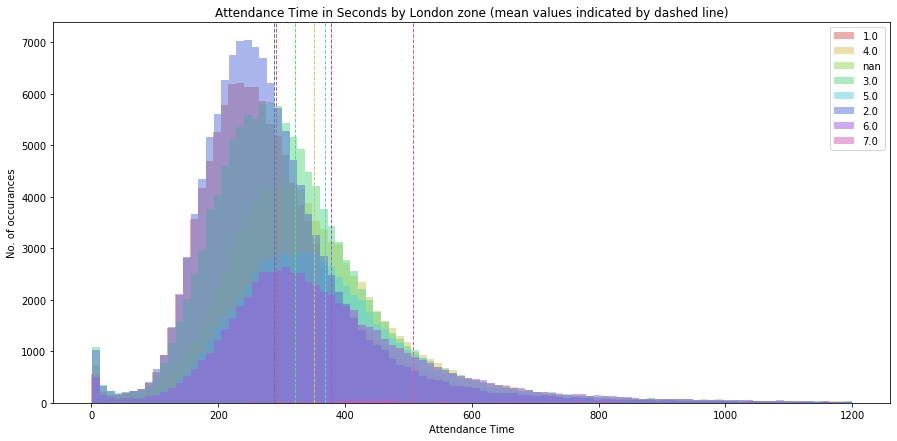

In [29]:
histogram_plot('London zone')

In [35]:
pivot_group(df['London zone'])

Range between mean values:  220.4  seconds


Here it can be seen that the delay codes have a range of 99 seconds. It's also interesting to note that the average attendance time is the highest when the address was incomplete or wrong. Which is not very surpising but highlights the importance of the responder's need of getting high quality information.
However in most incidents the trucks are not held up, even when the average response time is over 470 seconds (almost 8 minutes)

In [37]:
pivot_group(df['DelayCode_Description'])

Range between mean values:  99.0  seconds


Range between mean values:  99.0  seconds.


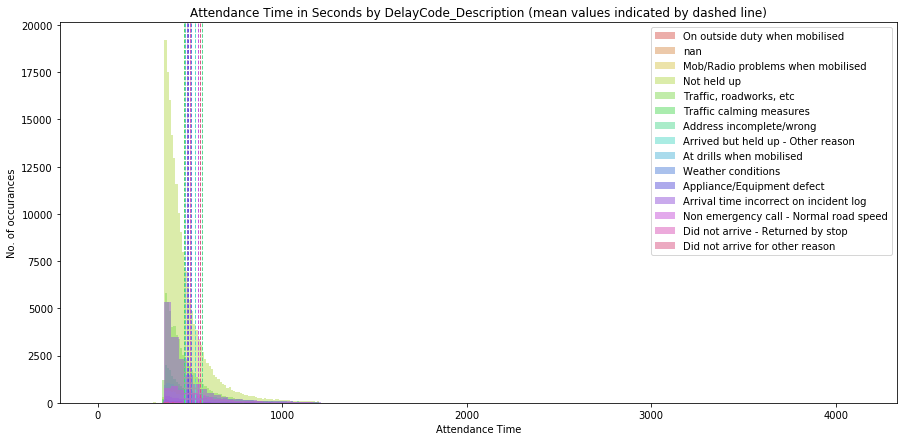

In [30]:
histogram_plot('DelayCode_Description')

From the below plots it can be seen that the weather description has some effect, with the response time being on average slightly higher when there is solid precipatation not in showers.

In [38]:
pivot_group(df['Description'])

Range between mean values:  43.9  seconds


Range between mean values:  44.0  seconds.


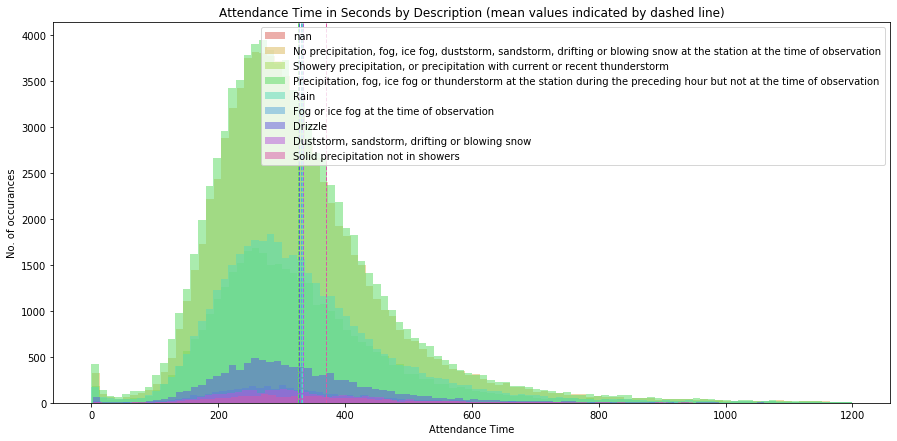

In [31]:
histogram_plot('Description')

The difference between the average responce times for different days is very small, but it is interesting to note that Sunday (day 6) has considerably higher number of incident calls.

Range between mean values:  8.0  seconds.


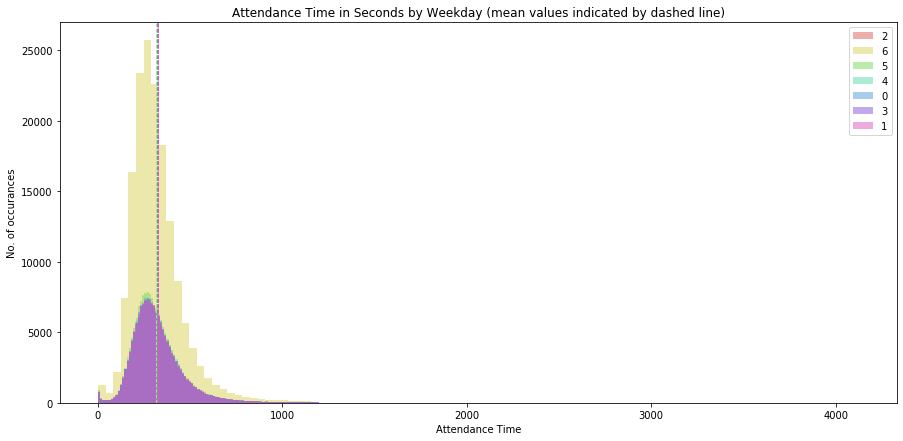

In [32]:
histogram_plot('Weekday')

### 2.4 Exploring maps data
Now lets explore how the different geographical locations seem to effect the attendance time. Looking at the table below we can see that the range is pretty high, 114 seconds, almost 2 minutes. The attendance times is the highest in Hillingdon and lowest in Kensington and Chelsea. To get a better feeling, lets explore the different attendance times on a choropleth graph so that we can see where those buroughs are located.

In [31]:
pivot_group(df.ProperCase[df.ProperCase != 'Not geo-coded'])

Range between mean values:  114.4  seconds


In order to create a Choropleth graphs it was necessary to get the shapefile of the London Boroughs. The shapefiles are available for download [here](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). 

Contains National Statistics data 
© Crown copyright and database right [2015] 

Contains Ordnance Survey data 
© Crown copyright and database right [2015]

The code below has been highly adapted from the tutorials [here](https://www.data-dive.com/cologne-bike-rentals-interactive-map-bokeh) and [here](https://www.data-dive.com/cologne-bike-rentals-interactive-map-bokeh-dynamic-choropleth)

In [39]:
shapefile = 'Shapefiles/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
shp = fiona.open(shapefile)
# Getting the features of the shapefile
borough_name_new = []
borough_code_new = []
borough_x_new = []
borough_y_new = []

for i, feat in enumerate(shp):
    
    borough_name_new.append(feat["properties"]["NAME"])
    borough_code_new.append(feat["properties"]["GSS_CODE"])
    
    if feat["geometry"]["type"] == 'MultiPolygon':
        multipolygon = feat["geometry"]["coordinates"]
        testing = feat["geometry"]["coordinates"]
        xs = []
        ys = []
        for m in multipolygon:
            xs.extend([x[0] for x in m[0]])
            ys.extend([y[1] for y in m[0]])
            
        borough_x_new.append(xs)
        borough_y_new.append(ys)
            
    else :
        y_values = [y[1] for y in feat["geometry"]["coordinates"][0]]
        x_values = [x[0] for x in feat["geometry"]["coordinates"][0]]
        borough_x_new.append(x_values)
        borough_y_new.append(y_values)

# To make things clearer we reorder the boroughs so the first one has the lowest borough code
idx = np.argsort(borough_code_new)

borough_name_new = np.array(borough_name_new)[idx]
borough_code_new = np.array(borough_code_new)[idx]
borough_x_new = np.array(borough_x_new)[idx]
borough_y_new = np.array(borough_y_new)[idx]

In [40]:
# Prepare the data we want displayed in each borough_code
test_data = df.groupby(['IncGeo_BoroughCode', 'ProperCase']).mean().reset_index()
test_data = test_data[['IncGeo_BoroughCode', 'ProperCase', 'AttendanceTimeSeconds']].set_index('IncGeo_BoroughCode')
test_data = test_data[test_data.ProperCase != 'Not geo-coded']

In [41]:
# prepare the plotting with bokeh
custom_colors = ['#f2f2f2', '#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
color_mapper = LogColorMapper(palette=custom_colors)    

source = ColumnDataSource(data=dict(
    x = borough_x_new, 
    y = borough_y_new,
    code = borough_code_new, 
    name = borough_name_new, 
    rate = round(test_data.AttendanceTimeSeconds)
))

In [42]:
# Interactivity
TOOLS = "pan,wheel_zoom,reset,hover,save"
p = figure(
    title="Average first response time in seconds by London buroughs", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,  plot_width=600, plot_height=450#plot_width=800, plot_height=600
)
p.grid.grid_line_color = None
p.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.0)

GlyphRenderer(id='1036', ...)

In [43]:
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
                  ("Borough name", "@name"),
                  ("Borough code", "@code"),
                  ("Average response (in sec)", "@rate") 
                  #("TEST²", "@rate2"),
                  #("(Long, Lat)", "($x, $y)")
                 ]

output_notebook()
output_file("kbl_bokeh_choropleth_2.html")
show(p)

Loading BokehJS ...

From the results above (shown in a printscreen below) it is clear that the central areas of London have a lower average response time than the outskirts.
![Img](https://github.com/kristin14/GitTest/blob/master/choropleth1.png?raw=true)

### Attendance Time after HourOfCall and Borough
Now it will be interesting to explore how the response times have changes based on the Hour of Call

In [44]:
# Prepare the data we want displayed in each borough_code and hour - VERY IMPORTANT THAT THE ORDERING IS THE SAME as with shapefiles
test_data2 = df.groupby(['IncGeo_BoroughCode', 'HourOfCall']).mean().reset_index()
test_data2 = test_data2[test_data2.IncGeo_BoroughCode != 'E00000000']
test_data2 = test_data2[['IncGeo_BoroughCode', 'HourOfCall', 'AttendanceTimeSeconds']].set_index(['HourOfCall', 'IncGeo_BoroughCode'])
test_data2.head()


AttendanceTimeSeconds
HourOfCall IncGeo_BoroughCode                       
0          E09000001                      283.093023
1          E09000001                      289.006645
2          E09000001                      301.562738
3          E09000001                      311.494253
4          E09000001                      311.394619

In [45]:
# Convert all the 
all_times = []
for hour, new_df in test_data2.groupby(level=0):
    times = []
    for code, new_df2 in new_df.groupby(level=1):
        #print("Code: ", code)
        #print("Hour: ", hour)
        #print("AttendanceTime: ", round(new_df2.AttendanceTimeSeconds))
        times.extend(round(new_df2.AttendanceTimeSeconds))
    all_times.append(times)

In [46]:
# Now we have a list of lists where each index is the hour and each hour contains 33 elements for all the boroughs
len(all_times[0])

33

In [47]:
rate_hours = {str(i): v for i, v in enumerate(all_times)} # from list to dict

In [48]:
data2 = dict(
    x = borough_x_new, 
    y = borough_y_new,
    code = borough_code_new, 
    name = borough_name_new, 
    rate = all_times[0], # The time at midnight - 1
    **rate_hours) # merge dictionaries
source2 = ColumnDataSource(data2) # one col per obsv. period

In [49]:
p2 = figure(
    title="Average first response time in seconds by London buroughs by hour", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,  plot_width=600, plot_height=450#plot_width=800, plot_height=600
)
p2.grid.grid_line_color = None
p2.patches('x', 'y', source = source2,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.0)

GlyphRenderer(id='1209', ...)

In [50]:
hover2 = p2.select_one(HoverTool)
hover2.point_policy = "follow_mouse"
hover2.tooltips = [
                  ("Borough name", "@name"),
                  ("Borough code", "@code"),
                  ("Average response (in sec)", "@rate") 
                  #("TEST²", "@rate2"),
                  #("(Long, Lat)", "($x, $y)")
                 ]
#output_notebook()
#show(p2)

Now we make the functionality to switch between different hours using a slider

In [51]:
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle

output_file("bokeh_kbl_hours.html")

# add slider with callback to update data source
slider = Slider(start=0, end=23, value=0, step=1, title="Hour of day")

In [52]:
callback = CustomJS(args=dict(p = p2, source = source2), code="""
    var data = source.data;
    var j = cb_obj.value;
    p.title.text = "Average response time in seconds per burough in period: " +j;
    data['rate'] = data[j];
    source.change.emit();
""")

In [53]:
slider.js_on_change('value', callback)
#show(column(p2,column(slider),))

In [54]:
output_file("bokeh_kbl_hours_animation.html")

callback2 = CustomJS(args=dict(p = p2, source = source2, slider = slider), code="""
    var data = source.data;
    var f = cb_obj.active;
    var j = 0;
    var mytimer = 0;
    
    if(f == true){
        console.log("START PLEASE")
        mytimer = setInterval(replace_data, 500);
        console.log("Mytimer: ", mytimer);
    } else {
        console.log("STOP PLEASE");
        for (var i = 1; i < 99999; i++)
            {window.clearInterval(i);}
    }
    
    function replace_data() {
        j++;
        if(data[j] == undefined) {
            j=0;
        }
        p.title.text = "Average response time in seconds per burough in period: " +j;
        data['rate'] = data[j];
        slider.value = j;
        source.change.emit();
    }
""")

In [55]:
btn = Toggle(label='Play/Stop Animation', button_type="success", active=False)
btn.js_on_change('active', callback2)
show(column(p2, slider, btn))

![Img](https://github.com/kristin14/GitTest/blob/master/choropleth2.png?raw=true)
From the above graph using the slider it is possible to visualize the changes in average response time with different hours of the day. For example there seems to be a higher number of areas with high average respons times between 17:00-17:59 than any other time of the day

### Attendance Time after Year and Borough
Lets explore how the attendance time has developed over the years, using the same functionality as before.

In [56]:
# create a new column that combines year and month so we get more granularity for the data
df['YearMonth'] = df['CalYear'].astype(str) + "-" + df['Month'].astype(str).str.pad(width=2, side='left', fillchar='0')

In [57]:
# Prepare the data we want displayed in each borough_code and hour - VERY IMPORTANT THAT THE ORDERING IS THE SAME as with shapefiles
df_ym = df.groupby(['IncGeo_BoroughCode', 'CalYear']).mean().reset_index()
df_ym = df_ym[df_ym.IncGeo_BoroughCode != 'E00000000'] # skip non geo coded values
df_ym = df_ym[['IncGeo_BoroughCode', 'CalYear', 'AttendanceTimeSeconds']].set_index(['CalYear', 'IncGeo_BoroughCode'])
df_ym.head()

AttendanceTimeSeconds
CalYear IncGeo_BoroughCode                       
2009    E09000001                      288.017330
2010    E09000001                      285.170347
2011    E09000001                      294.680454
2012    E09000001                      293.714034
2013    E09000001                      281.880931

In [58]:
# Convert all the 
all_times = []
for hour, new_df in df_ym.groupby(level=0):
    times = []
    for code, new_df2 in new_df.groupby(level=1):
        #print("Code: ", code)
        #print("Hour: ", hour)
        #print("AttendanceTime: ", round(new_df2.AttendanceTimeSeconds))
        times.extend(round(new_df2.AttendanceTimeSeconds))
    all_times.append(times)

In [59]:
len(all_times)

12

In [66]:
rate_hours = {str(i): v for i, v in enumerate(all_times)} # from list to dict

data3 = dict(
    x = borough_x_new, 
    y = borough_y_new,
    code = borough_code_new, 
    name = borough_name_new, 
    rate = all_times[0], # The time at midnight - 1
    **rate_hours) # merge dictionaries
source3 = ColumnDataSource(data3) # one col per obsv. period

p3 = figure(
    title="Average response time in seconds by London buroughs by year: 2009", tools=TOOLS,
    toolbar_location = None,
    x_axis_location=None, y_axis_location=None,  plot_width=600, plot_height=450#plot_width=800, plot_height=600
)
p3.grid.grid_line_color = None
p3.patches('x', 'y', source = source3,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.8, line_color="black", line_width=0.0)

hover3 = p3.select_one(HoverTool)
hover3.point_policy = "follow_mouse"
hover3.tooltips = [
                  ("Borough name", "@name"),
                  ("Borough code", "@code"),
                  ("Average response (in sec)", "@rate") 
                 ]

show(p3)

In [67]:
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle

# add slider with callback to update data source
slider3 = Slider(start=2009, end=2020, value=2009, step=1, title="Year")

In [68]:
callback3 = CustomJS(args=dict(p = p3, source = source3), code="""
    var data = source.data;
    var j = cb_obj.value;
    p.title.text = "Average response time in seconds per borough in period: " +j;
    j = j - 2009;
    console.log(data[j])
    data['rate'] = data[j];
    
    source.change.emit();
""")

In [69]:
slider3.js_on_change('value', callback3)
#show(column(p3,column(slider3),))

In [70]:
callback4 = CustomJS(args=dict(p = p3, source = source3, slider = slider3), code="""
    var data = source.data;
    var f = cb_obj.active;
    var j = 2009;
    var mytimer = 0;
    
    if(f == true){
        console.log("START PLEASE")
        mytimer = setInterval(replace_data, 500);
        console.log("Mytimer: ", mytimer);
    } else {
        console.log("STOP PLEASE");
        for (var i = 1; i < 99999; i++)
            {window.clearInterval(i);}
    }
    
    function replace_data() {
        j++;
        if(data[j-2009] == undefined) {
            j=2009;
        }
        p.title.text = "Average response time in seconds per borough in period: " +j;
        data['rate'] = data[j-2009];
        slider.value = j;
        source.change.emit();
    }
""")

In [71]:
btn3 = Toggle(label='Play/Stop Animation', button_type="success", active=False)
btn3.js_on_change('active', callback4)
output_file("bokeh_kbl_years_new.html")
show(column(p3, slider3, btn3))

![Img](https://github.com/kristin14/GitTest/blob/master/choropleth3.png?raw=true)
From the above Bokeh graph it is clear that over the years there have been some changes.
When the animation is run it is clear that some buroughs always have a high average response times while others always have a low average response time.

# Exploring the differences between Chelsea & Kensington and Hillingdon

In [271]:
pd.set_option('display.max_columns', None)
ck = df[df.IncGeo_BoroughCode == 'E09000020'] # Chelsea and Kensington
hillingdon = df[df.IncGeo_BoroughCode == 'E09000017']

In [272]:
# calculate the mean response time based on ward name - CODES DO NOT MATCH
ck_group = ck.groupby('WardCode').mean().round().reset_index()
hillingdon_group = hillingdon.groupby('WardCode').mean().round().reset_index()
hillingdon_group.head()

WardCode  CalYear  HourOfCall   Easting  Northing  \
0  E05000324   2014.0        14.0  510527.0  181747.0   
1  E05000325   2014.0        13.0  508935.0  180302.0   
2  E05000326   2013.0        13.0  506828.0  182012.0   
3  E05000327   2015.0        14.0  511177.0  186930.0   
4  E05000328   2014.0        14.0  509330.0  182562.0   

   FirstPumpArriving_AttendanceTime  SecondPumpArriving_AttendanceTime  \
0                             415.0                              464.0   
1                             346.0                              425.0   
2                             287.0                              378.0   
3                             439.0                              496.0   
4                             371.0                              402.0   

   NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
0                            1.0                2.0        2.0   
1                            1.0                2.0        2.0   
2                            1.0                2.0        2.0   
3                            1.0                2.0        2.0   
4                            1.0                2.0        2.0   

   PumpHoursRoundUp  Notional Cost (£)  Population  Households  Altitude  \
0               2.0              515.0        68.0        22.0      34.0   
1               1.0              420.0        55.0        19.0      37.0   
2               1.0              485.0       332.0        20.0      42.0   
3               1.0              370.0        65.0        27.0      46.0   
4               1.0              464.0        65.0        23.0      36.0   

   London zone  Average Income  Latitude  Longitude  ResourceMobilisationID  \
0          5.0         49945.0      52.0       -0.0               4158477.0   
1          5.0         48183.0      52.0       -0.0               4190240.0   
2          6.0         54754.0      52.0       -0.0               4038347.0   
3          5.0         59207.0      52.0       -0.0               4389653.0   
4          5.0         51236.0      52.0       -0.0               4150963.0   

   AttendanceTimeSeconds  MobilisationOrder  DelayCodeID  Month  Week  \
0                  419.0                1.0          8.0    7.0  27.0   
1                  347.0                1.0          5.0    7.0  27.0   
2                  288.0                1.0          3.0    6.0  26.0   
3                  444.0                1.0         10.0    7.0  26.0   
4                  370.0                1.0          5.0    6.0  26.0   

   Weekday  wind_speed_unit_id  wind_direction  wind_speed  visibility  \
0      3.0                 4.0           191.0         9.0      2290.0   
1      3.0                 4.0           195.0         8.0      2290.0   
2      3.0                 4.0           197.0         8.0      2249.0   
3      3.0                 4.0           197.0         9.0      2439.0   
4      3.0                 4.0           200.0         8.0      2304.0   

   msl_pressure  air_temperature  snow_depth  drv_hr_sun_dur  
0        1015.0             13.0         4.0             0.0  
1        1016.0             13.0         4.0             0.0  
2        1015.0             13.0         4.0             0.0  
3        1015.0             13.0         5.0             0.0  
4        1015.0             13.0         4.0             0.0

In [273]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

In [290]:
shp2 = 'Shapefiles/London-wards-2014/London-wards-2014_ESRI/London_Ward.shp'
gdf2 = gpd.read_file(shp2)
#gdf2 = gdf2.to_crs(epsg=4326)

gdf_ck = gdf2[gdf2.LB_GSS_CD == 'E09000020']
gdf_h = gdf2[gdf2.LB_GSS_CD == 'E09000017']
gdf_h.head()

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
123  Heathrow Villages  E05000331  2352.117         0.0  E09000017   
124          Harefield  E05000330  1522.704         0.0  E09000017   
125       West Drayton  E05000342   349.070         0.0  E09000017   
126           Yiewsley  E05000345   402.251         0.0  E09000017   
127     Uxbridge South  E05000341   311.447         0.0  E09000017   

        BOROUGH  POLY_ID                                           geometry  
123  Hillingdon   116716  POLYGON ((503611.200 175520.400, 503613.300 17...  
124  Hillingdon    51039  POLYGON ((504785.000 187625.000, 504770.300 18...  
125  Hillingdon   116720  POLYGON ((504913.200 178373.200, 504918.800 17...  
126  Hillingdon   116722  POLYGON ((505195.600 180097.800, 505194.500 18...  
127  Hillingdon   116718  POLYGON ((505777.100 183350.800, 505766.700 18...

In [291]:
# CHecking the coordinate system used
gdf2.crs

{'proj': 'tmerc',
 'lat_0': 49,
 'lon_0': -2,
 'k': 0.999601272,
 'x_0': 400000,
 'y_0': -100000,
 'datum': 'OSGB36',
 'units': 'm',
 'no_defs': True}

Now we merge the geofiles with the data based on the ward code.

In [292]:
gdf_ck_merged = gdf_ck.merge(ck_group[['WardCode', 'AttendanceTimeSeconds']], left_on='GSS_CODE', right_on='WardCode', how='left')
gdf_ck_merged.head(2)


NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0  Chelsea Riverside  E05009391    69.412      15.654  E09000020   
1            Holland  E05009397    98.278       0.000  E09000020   

                  BOROUGH  POLY_ID  \
0  Kensington and Chelsea   125786   
1  Kensington and Chelsea   125791   

                                            geometry   WardCode  \
0  POLYGON ((526027.600 177216.200, 526067.100 17...  E05009391   
1  POLYGON ((523843.700 179903.000, 523850.600 17...  E05009397   

   AttendanceTimeSeconds  
0                  266.0  
1                  331.0

In [293]:
gdf_h_merged = gdf_h.merge(hillingdon_group[['WardCode', 'AttendanceTimeSeconds']], left_on='GSS_CODE', right_on='WardCode', how='left')
gdf_h_merged.head(2)

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD     BOROUGH  \
0  Heathrow Villages  E05000331  2352.117         0.0  E09000017  Hillingdon   
1          Harefield  E05000330  1522.704         0.0  E09000017  Hillingdon   

   POLY_ID                                           geometry   WardCode  \
0   116716  POLYGON ((503611.200 175520.400, 503613.300 17...  E05000331   
1    51039  POLYGON ((504785.000 187625.000, 504770.300 18...  E05000330   

   AttendanceTimeSeconds  
0                  404.0  
1                  526.0

Now the geoshapefiles with data are ready for plotting

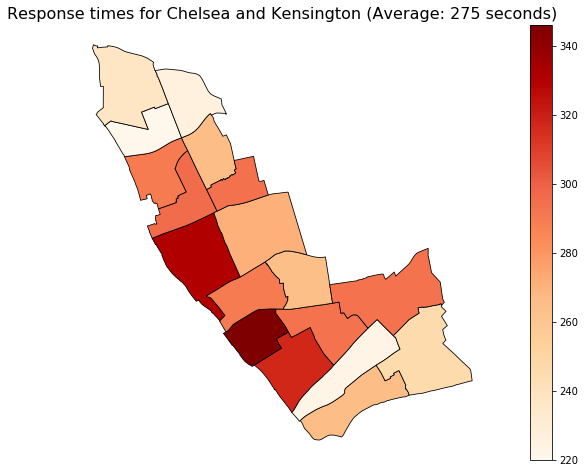

In [294]:
avg_ck = round(ck.AttendanceTimeSeconds.mean());
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_ck_merged.plot(column='AttendanceTimeSeconds', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Response times for Chelsea and Kensington (Average: %s seconds)' %avg_ck, fontsize=16);

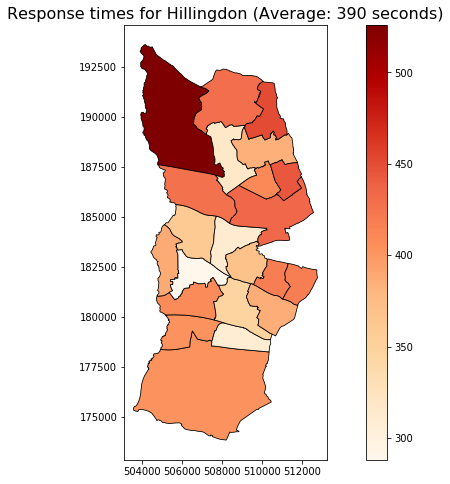

In [295]:
avg_h = round(hillingdon.AttendanceTimeSeconds.mean());
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_h_merged.plot(column='AttendanceTimeSeconds', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
#ax.axis('off');
ax.set_title('Response times for Hillingdon (Average: %s seconds)' %avg_h, fontsize=16);

Next it will be very interesting to plot the locations of the fire stations into the graphs. Based on the information provided by the LFB there are three locations in [Kensington and Chelsea](https://www.london-fire.gov.uk/community/kensington-and-chelsea/) and four locations in [Hillingdon](https://www.london-fire.gov.uk/community/hillingdon/). Using the https://gridreferencefinder.com/ we are able to find the easting and northing locations of the stations.

In [394]:
# Converting stations to easting and northing coordinates
hillingdon_df = pd.DataFrame(
    {'Name': ['Hayes', 'Heathrow', 'Hillingdon', 'Ruislip'],
     'Easting': [508968, 507134 , 507470, 508405],
     'Northing': [178447, 176819, 182597, 188883]})

hillingdon_gdf_stations = gpd.GeoDataFrame(
    hillingdon_df, geometry=gpd.points_from_xy(hillingdon_df.Easting, hillingdon_df.Northing))


ck_df = pd.DataFrame(
    {'Name': ['Chelsea', 'Kensington', 'North Kensington'],
     'Easting': [527144, 525717, 524085],
     'Northing': [178063, 179778, 181936]})

ck_gdf_stations = gpd.GeoDataFrame(
    ck_df, geometry=gpd.points_from_xy(ck_df.Easting, ck_df.Northing))

# Collecting incident data
hillingdon_incidents = hillingdon[['Easting', 'Northing']].dropna()

hillingdon_gdf_incidents = gpd.GeoDataFrame(
    hillingdon_incidents, geometry=gpd.points_from_xy(hillingdon_incidents.Easting, hillingdon_incidents.Northing))

ck_incidents = ck[['Easting', 'Northing']].dropna()

ck_gdf_incidents = gpd.GeoDataFrame(
    ck_incidents, geometry=gpd.points_from_xy(ck_incidents.Easting, ck_incidents.Northing))

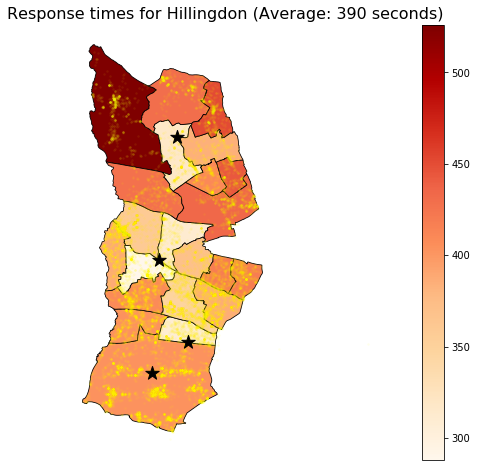

In [415]:
avg_h = round(hillingdon.AttendanceTimeSeconds.mean());
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_h_merged.plot(column='AttendanceTimeSeconds', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Response times for Hillingdon (Average: %s seconds)' %avg_h, fontsize=16);

hillingdon_gdf_incidents.plot(ax=ax, color='yellow', alpha = 0.05, markersize = 3);
hillingdon_gdf_stations.plot(ax=ax, color='black', marker='*', markersize = 200);

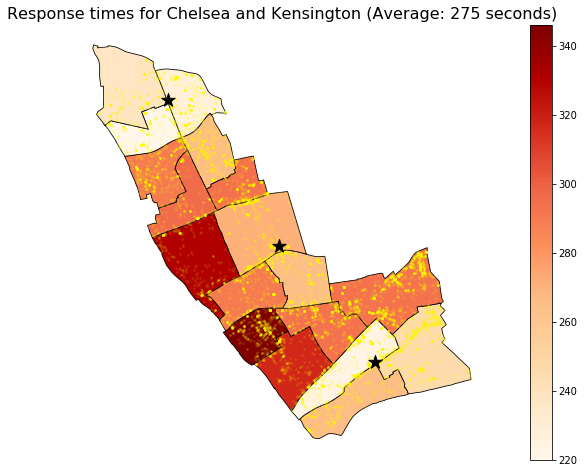

In [414]:
avg_ck = round(ck.AttendanceTimeSeconds.mean());
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_ck_merged.plot(column='AttendanceTimeSeconds', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Response times for Chelsea and Kensington (Average: %s seconds)' %avg_ck, fontsize=16);

ck_gdf_incidents.plot(ax=ax, color='yellow', alpha = 0.1, markersize = 3);
ck_gdf_stations.plot(ax=ax, color='black', marker='*', markersize = 200);

Lets try plotting them on the same graph

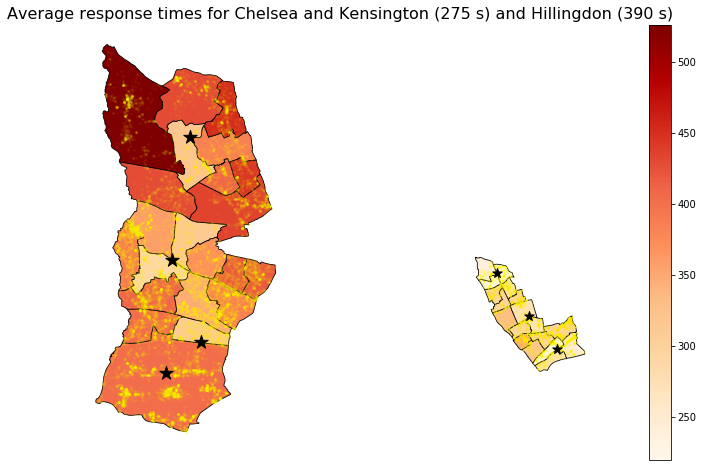

In [431]:
avg_ck = round(ck.AttendanceTimeSeconds.mean());
fig, ax = plt.subplots(1, figsize=(14, 8));

gdf_merged_total = gdf_ck_merged.append(gdf_h_merged)


gdf_merged_total.plot(column='AttendanceTimeSeconds', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Average response times for Chelsea and Kensington (%s s) and Hillingdon (%s s)' %(avg_ck, avg_h), fontsize=16);

ck_gdf_incidents.plot(ax=ax, color='yellow', alpha = 0.05, markersize = 1);
ck_gdf_stations.plot(ax=ax, color='black', marker='*', markersize = 100);

hillingdon_gdf_incidents.plot(ax=ax, color='yellow', alpha = 0.05, markersize = 3);
hillingdon_gdf_stations.plot(ax=ax, color='black', marker='*', markersize = 200);

In [433]:
len(ck)

34570

In [434]:
len(hillingdon)

37424